In [1]:
import numpy as np
import pandas as pd

from scipy.stats import norm
from scipy.integrate import simps
from scipy.optimize import brentq

import sys
import dill

from functools import partial
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk')

In [3]:
from matplotlib.ticker import FuncFormatter

In [4]:
formatter_tex_bps = FuncFormatter(lambda y, pos: "$%.0f$" % (10**4 * y))

def formatter_tex_time(x, pos):
    if x == 0.:
        return r'$\rm{0 \, y}$'
    
    str_x = str(x)
    
    if str_x[-1] == '0':
        return r'$\rm{%s \, y}$' % (str_x[:-2])

    return r'$\rm{%s \, y}$' % (str_x)

formatter_tex_time = FuncFormatter(formatter_tex_time)

In [5]:
def formatter_tex_time(x, pos):
    if x == 0.:
        return r'$\rm{0}$'
    
    str_x = str(x)
    
    if str_x[-1] == '0':
        return r'$\rm{%s}$' % (str_x[:-2])

    return r'$\rm{%s}$' % (str_x)

formatter_tex_time = FuncFormatter(formatter_tex_time)

In [6]:
labelsize = 18
titlesize = 20

In [7]:
sys.path.append('..')

In [8]:
from finance.discountfactor import ConstantRateDiscountFactor
from finance.products.european.swap import SwapContract
from utils import time_offseter

loaded_data = None

with open('precomputed_sims/data1.pkl', 'rb') as f:
    loaded_data = dill.load(f)
    
step = 1 / 360.
delta = 5 * step

maturity = loaded_data["randomization"]["maturity"]
print "Maturity = %s years" % maturity

R = 0.02
H = 0.1
discount = ConstantRateDiscountFactor(R)

udlyings = loaded_data["underlyings"]
print "Maximum number of paths: %i" % len(udlyings)

GBM0 = udlyings[0]
kappa = GBM0.drifts[0][0]
sigma = GBM0.vols[0][0]
print "kappa = %s, sigma = %s" % (kappa, sigma)

time_grid = GBM0.time

derivatives_nb = 1

swap_delta = 0.25
swap_dates = SwapContract.generate_payment_dates(0, maturity, swap_delta)
swap = SwapContract(GBM0, discount, swap_dates)

print swap

p_fixed = 1.
strike = swap.strike

delta_times = swap.delta_time
discount_factors = [discount(t) for t in swap.pillars[1:]]

delta_beta_sum = np.dot(delta_times, discount_factors)

notional = p_fixed / (strike * delta_beta_sum)

print "Notional on the swap: %s" % notional

copula = loaded_data["credit"]["copula"]
c_subsets_indexes = loaded_data["credit"]["bc_subsets_indexes"]
obligors_nb = len(copula.subsets[c_subsets_indexes[-1]][0])
print "Obligor numbers: %s" % obligors_nb

c_ids = [17, 9, 29, 26, 50, 4, 5, 13, 64]
c_positions = [0.69, -0.46, -0.44, -0.36, 0.34, 0.23, 0.09, -0.05, -0.04]

print "Counterparties id: %s (nb = %s)" % (c_ids, len(c_ids))

POSITIONS = np.zeros(obligors_nb)
for idx, ps in zip(c_ids, c_positions):
    POSITIONS[idx] = ps

POSITIONS = POSITIONS / -POSITIONS[13]
POSITIONS = np.array(POSITIONS).flatten()

print POSITIONS

spreads = [176, 45, 367, 1053, 73, 56, 52, 61, 108]
IDS_SPREADS = dict((id_, spread_) for (id_, spread_) in zip(c_ids, spreads))
IDS_POSITIONS = dict((id_, pos_) for (id_, pos_) in zip(c_ids, c_positions))

Maturity = 5.0 years
Maximum number of paths: 20000
kappa = 0.12, sigma = 0.2
Swap contract of maturity T = 5 years, over S^0 with strike K = 134.306, paying at {0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00, 3.25, 3.50, 3.75, 4.00, 4.25, 4.50, 4.75, 5.00}
Notional on the swap: 0.0015687485053
Obligor numbers: 125
Counterparties id: [17, 9, 29, 26, 50, 4, 5, 13, 64] (nb = 9)
[  0.    0.    0.    0.    4.6   1.8   0.    0.    0.   -9.2   0.    0.
   0.   -1.    0.    0.    0.   13.8   0.    0.    0.    0.    0.    0.
   0.    0.   -7.2   0.    0.   -8.8   0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    6.8   0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.   -0.8   0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    

In [9]:
QUANTIME_IM = 0.85
QUANTILE_ES = 0.99

RECOV = 0.4
S0 = GBM0(0.)[0, 0]

HURDLED_DISCOUNT = ConstantRateDiscountFactor(R + H)

LOIM_PATH = './res/aggregated/loss_over_im'
CVA_PATH = './res/aggregated/cva_ccp'

times_cva = np.arange(0, maturity, 0.5)

shifted_times_cva = times_cva + 1.
shifted_times_cva[-1] = maturity

In [10]:
def fact_(swap_, discount_, kappa_, delta_, t_):
    time_grid_ = swap_.underlying.time
    t_delta_ = time_offseter(t_ + delta_, time_grid_, True)
    
    coupon_dates_ = swap_.pillars
    l_t_delta_ = np.searchsorted(coupon_dates_, t_delta_, side='left')

    beta_T_l_ = map(discount_, coupon_dates_[l_t_delta_ + 1 :])    
    h_l_ = swap_.delta_time[l_t_delta_ : ]
    
    T_l_m1_ = kappa_ * coupon_dates_[l_t_delta_ : -1]
    exp_factor_ = map(np.exp, T_l_m1_)
    
    tmp_ = np.multiply(exp_factor_, h_l_)    
    res_ = np.dot(beta_T_l_, tmp_)
    
    return res_

fact = partial(fact_, swap, discount, kappa, delta)

In [11]:
def B_(fact_f_, vol_, delta_, a_, omega_, t_):
    if a_ <= 0.5: 
        a_ = 1. - a_
    
    perc_ = a_ if omega_ <= 0. else (1. - a_)
    q_ = norm.ppf(perc_)
    
    var_ = vol_**2 * delta_
    exp_factor_ = np.exp(-0.5 * var_ + np.sqrt(var_) * q_)
    
    tmp_res_ = 1. - exp_factor_
    
    return np.sign(omega_) * tmp_res_ * fact_f_(t_)

B = partial(B_, fact, sigma, delta)

In [12]:
def C_(fact_f_, vol_, delta_, t_):
    x_ = 0.5 * vol_ * np.sqrt(delta_)
    fact_ = fact_f_(t_)
    
    cdf1 = norm.cdf(x_)
    cdf2 = norm.cdf(-x_)
    
    return fact_ * (cdf1 - cdf2)

C = partial(C_, fact, sigma, delta)

In [13]:
def A_(fact_f_, vol_, delta_, a_, omega_, t_):
    if a_ <= 0.5: 
        a_ = 1. - a_
    
    var_ = vol_**2 * delta_
    
    perc_ = a_ if omega_ <= 0. else (1. - a_)
    q_ = norm.ppf(perc_)
    sqrt_var_ = np.sqrt(var_)
    var_factor_ = np.exp(sqrt_var_ * q_)
    
    sgn_omega_ = np.sign(omega_)
    es_gauss_ = - norm.pdf(norm.ppf(a_)) / (1. - a_) * sgn_omega_
    es_factor_ = np.exp(sqrt_var_ * es_gauss_)
    
    diff_term_ = (var_factor_ - es_factor_) * sgn_omega_
    
    comm_factor_ = (1. - a_) * fact_f_(t_) * np.exp(-0.5 * var_)
    
    res_ = comm_factor_ * diff_term_
    return res_

A = partial(A_, fact, sigma, delta)

In [14]:
mva0_ul = pd.Series(index=c_ids)

for id_ in c_ids:
    pos_ = POSITIONS[id_]
    nom_i = np.abs(pos_) * notional
    
    factor = S0 * (1 - RECOV) * nom_i
    
    def integrand(t_):
        Bt_ = B(QUANTIME_IM, pos_, t_)
        gamma_t_ = copula.tot_gamma(t_, id_)
        surv_proba_t_ = copula.tot_survival_proba(t_, id_)
        
        return Bt_ * gamma_t_ * surv_proba_t_
        
    sub_indexes_ = copula.get_indexes_including(id_)
    int_pillars_ = set(copula.pillars[sub_indexes_].flatten())
    swap_pillars_ = set(swap.pillars)
            
    cut_times_ = list(int_pillars_ | swap_pillars_)
    cut_times_.sort()
        
    integral_ = 0.
    for t_i_, t_ip1_ in zip(cut_times_[:-1], cut_times_[1:]):
        x__ = np.linspace(t_i_, t_ip1_, 10)
        y__ = [integrand(x_i_) for x_i_ in x__]
        tmp_int__ = simps(y__, x__)
        integral_ += tmp_int__
            
    mva0 = factor * integral_
    mva0_ul[id_] = mva0
    
mva0_ul

17    0.014911
9     0.002659
29    0.019379
26    0.037329
50    0.003107
4     0.001700
5     0.000609
13    0.000383
64    0.000535
dtype: float64

In [15]:
mva0_sl = pd.Series(index=c_ids)

for id_ in c_ids:
    pos_ = POSITIONS[id_]
    nom_i = np.abs(pos_) * notional
    
    factor = S0 * (1 - RECOV) * nom_i
    
    def integrand(t_):
        Ct_ = C(t_)
        A_i_t_ = A(QUANTIME_IM, pos_, t_)
        gamma_t_ = copula.tot_gamma(t_, id_)
        surv_proba_t_ = copula.tot_survival_proba(t_, id_)
        
        return (Ct_ - A_i_t_) * gamma_t_ * surv_proba_t_
        
    sub_indexes_ = copula.get_indexes_including(id_)
    int_pillars_ = set(copula.pillars[sub_indexes_].flatten())
    swap_pillars_ = set(swap.pillars)
            
    cut_times_ = list(int_pillars_ | swap_pillars_)
    cut_times_.sort()
        
    integral_ = 0.
    for t_i_, t_ip1_ in zip(cut_times_[:-1], cut_times_[1:]):
        x__ = np.linspace(t_i_, t_ip1_, 10)
        y__ = [integrand(x_i_) for x_i_ in x__]
        tmp_int__ = simps(y__, x__)
        integral_ += tmp_int__
            
    mva0 = factor * integral_
    mva0_sl[id_] = mva0
    
mva0_sl

17    0.004660
9     0.000817
29    0.005958
26    0.011476
50    0.000971
4     0.000531
5     0.000190
13    0.000118
64    0.000165
dtype: float64

In [16]:
def map_id_label(c_id_):
    pos_ = POSITIONS[c_id_]
    spread_ =  IDS_SPREADS[c_id_]
    
    pos_string_ = "%.2f" % abs(pos_)
    if pos_ > 0:
        pos_string_ = "(" + pos_string_ + ")"
    
    res = r'$%i \rm{bps}$''\n''$%s$' % (spread_, pos_string_)
    
    return res

In [17]:
mva0 = pd.DataFrame(index=c_ids, columns=[r'$MVA_0^{sl}$', r'$MVA_0^{ub}$'])
mva0[r'$MVA_0^{sl}$'] = mva0_sl
mva0[r'$MVA_0^{ub}$'] = mva0_ul

mva0.index = mva0.index.map(map_id_label)

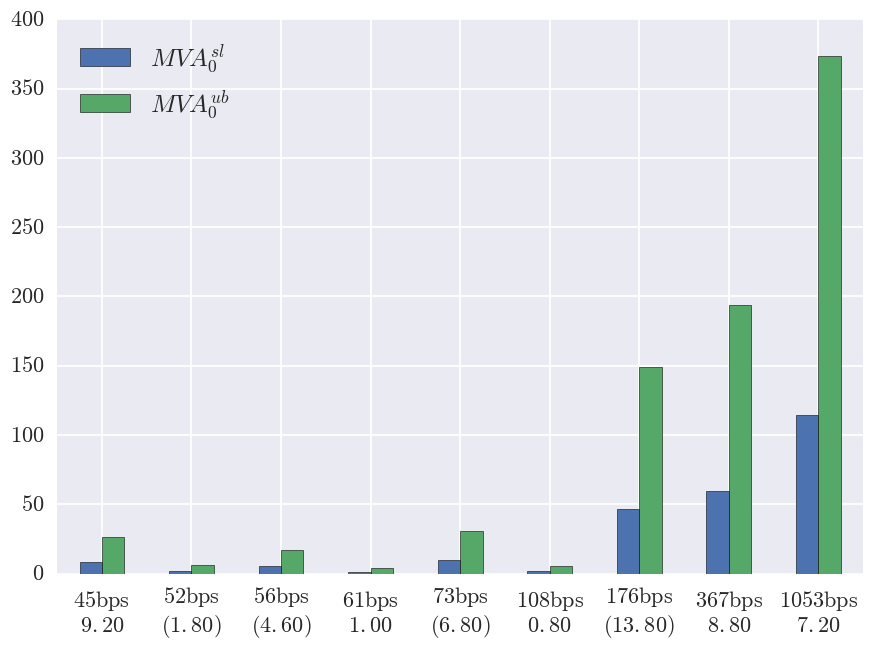

In [18]:
spreads = [176, 45, 367, 1053, 73, 56, 52, 61, 108]
ids_spreads = dict((id_, spread_) for (id_, spread_) in zip(c_ids, spreads))

sorted_bc_ids = sorted(ids_spreads.items(), key=lambda x: x[1])
sorted_bc_ids_spreads = [x[0] for x in sorted_bc_ids]

labels_spreads = map(map_id_label, sorted_bc_ids_spreads)

mva0 = mva0.reindex(labels_spreads)

mva0.plot.bar(rot=0)
plt.gca().yaxis.set_major_formatter(formatter_tex_bps)

plt.legend(loc='best', fontsize=labelsize)
plt.tick_params(axis='both', which='major', labelsize=labelsize-2)

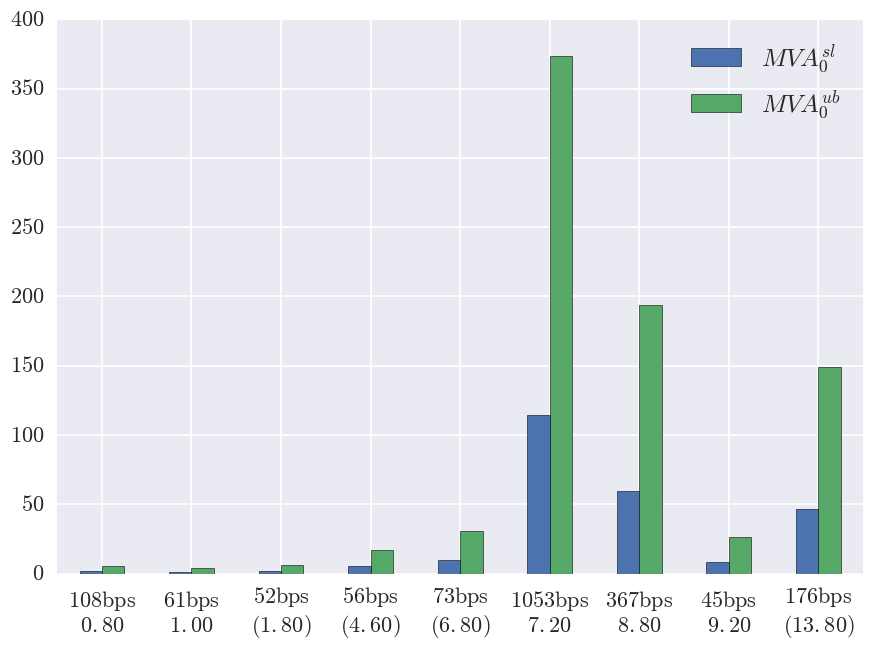

In [19]:
pos = [POSITIONS[kk] for kk in c_ids]
ids_pos = dict((id_, pos_) for (id_, pos_) in zip(c_ids, pos))

sorted_bc_ids = sorted(ids_pos.items(), key=lambda x: abs(x[1]))
sorted_bc_ids_positions = [x[0] for x in sorted_bc_ids]

labels_positions = map(map_id_label, sorted_bc_ids_positions)

mva0 = mva0.reindex(labels_positions)

mva0.plot.bar(rot=0)
plt.gca().yaxis.set_major_formatter(formatter_tex_bps)

plt.legend(loc='best', fontsize=labelsize)
plt.tick_params(axis='both', which='major', labelsize=labelsize-2)

In [20]:
cols = map(str, c_ids)
cols.append('all')

es_time = {}

for t0, t1 in zip(times_cva, shifted_times_cva):
    str_int = '[%.2f, %.2f]' % (t0, t1)
    
    fname = 'loim_%s_%s.csv' % (str_int, QUANTIME_IM)
    loim_q_path = os.path.join(LOIM_PATH, fname)
    loim_df = pd.read_csv(loim_q_path, header=0, index_col=0)
    
    fname = '%s/cva_%.2f.csv' % (QUANTIME_IM, t0)
    cva_q_path_t0 = os.path.join(CVA_PATH, fname)
    cva_t0_df = pd.read_csv(cva_q_path_t0, header=0, index_col=0)
        
    fname = '%s/cva_%.2f.csv' % (QUANTIME_IM, t1)
    cva_q_path_t1 = os.path.join(CVA_PATH, fname)
    cva_t1_df = pd.read_csv(cva_q_path_t1, header=0, index_col=0)
    
    es_time[t0] = {}
    
    for c in cols:
        loss = loim_df.copy()
        cva_t0 = cva_t0_df.copy()
        cva_t1 = cva_t1_df.copy()
        
        if c != 'all':
            loss = loss.drop(c, 1)
            cva_t0 = cva_t0.drop(c, 1)
            cva_t1 = cva_t1.drop(c, 1)

        all_loss = loss.sum(axis=1) + (discount(t1) * cva_t1.sum(axis=1)) - (discount(t0) * cva_t0.sum(axis=1))
        all_loss = all_loss / discount(t0)
            
        var = all_loss.quantile(QUANTILE_ES, interpolation='linear')
        es = all_loss[all_loss > var].mean()
        
        es_time[t0][c] = es
        
es_time = pd.DataFrame(es_time).transpose()
es_time

,13,17,26,29,4,5,50,64,9,all
0.0,0.274243,0.253533,0.196111,0.235026,0.273436,0.274128,0.272071,0.273247,0.267811,0.274570
0.5,0.262519,0.246990,0.183735,0.224078,0.261886,0.262540,0.260592,0.261926,0.257092,0.262906
1.0,0.274191,0.254719,0.198528,0.231529,0.273365,0.274225,0.271167,0.273553,0.266781,0.274747
1.5,0.274659,0.249889,0.203955,0.230252,0.273344,0.274448,0.270802,0.274086,0.267063,0.275221
2.0,0.259971,0.238354,0.195452,0.212050,0.258702,0.259897,0.257178,0.259176,0.254612,0.260339
2.5,0.224971,0.198369,0.168162,0.179049,0.223404,0.225044,0.219981,0.223839,0.215415,0.225845
3.0,0.173626,0.129203,0.146315,0.131819,0.171706,0.173652,0.164347,0.172293,0.159448,0.175104
3.5,0.132428,0.098546,0.111693,0.099407,0.131450,0.132724,0.124570,0.131490,0.121444,0.133670
4.0,0.063576,0.044793,0.053376,0.046925,0.063374,0.063880,0.059632,0.063181,0.058574,0.064291
4.5,0.029594,0.022450,0.026179,0.023210,0.026589,0.027168,0.026096,0.029826,0.025084,0.027194


In [21]:
es = es_time['all']
es

0.0    0.274570
0.5    0.262906
1.0    0.274747
1.5    0.275221
2.0    0.260339
2.5    0.225845
3.0    0.175104
3.5    0.133670
4.0    0.064291
4.5    0.027194
Name: all, dtype: float64

In [22]:
delta_ec = es_time.copy()

for c in cols:
    delta_ec[c] = delta_ec['all'] - delta_ec[c]

delta_ec[delta_ec < 0.] = 0.

delta_ec.drop('all', 1, inplace=True)
delta_ec = delta_ec.transpose()

for c in delta_ec.columns:
    delta_ec[c] = delta_ec[c] / delta_ec[c].sum()
    
delta_ec = delta_ec.transpose()
delta_ec

,13,17,26,29,4,5,50,64,9
0.0,0.002158,0.138834,0.517807,0.260976,0.007483,0.002916,0.016488,0.008731,0.044606
0.5,0.002675,0.109921,0.546761,0.268151,0.007049,0.002533,0.015985,0.006772,0.040152
1.0,0.003596,0.129492,0.492798,0.279432,0.008935,0.003375,0.023149,0.007719,0.051504
1.5,0.003546,0.159831,0.449651,0.283732,0.011844,0.004877,0.027880,0.007163,0.051476
2.0,0.002490,0.148889,0.439446,0.327035,0.011086,0.002994,0.021406,0.007873,0.038782
2.5,0.005661,0.177988,0.373665,0.303141,0.015814,0.005187,0.037984,0.012994,0.067566
3.0,0.009623,0.298982,0.187523,0.281941,0.022130,0.009455,0.070062,0.018307,0.101976
3.5,0.010411,0.294470,0.184252,0.287257,0.018610,0.007929,0.076289,0.018279,0.102504
4.0,0.011667,0.318023,0.178033,0.283255,0.014966,0.006709,0.075988,0.018108,0.093250
4.5,0.000000,0.349371,0.074695,0.293378,0.044512,0.001871,0.080822,0.000000,0.155350


In [23]:
kva_time = pd.DataFrame()

for c in es_time.columns:
    es_c = es_time[c]
    
    time_grid = np.append(times_cva, maturity)
    exp_factors = np.exp(-(R + H) * time_grid)
    delta_exp_factors = np.ediff1d(exp_factors)
    es_exp = es_c * delta_exp_factors
    
    kva = -H / (R + H) * es_exp
    kva = kva[::-1].cumsum()[::-1]
    
    kva_time[c] = kva
    
kva_time

,13,17,26,29,4,5,50,64,9,all
0.0,0.079102,0.070413,0.059092,0.065176,0.078653,0.079041,0.077554,0.078824,0.076259,0.079271
0.5,0.065793,0.058109,0.049575,0.053770,0.065383,0.065737,0.064350,0.065564,0.063262,0.065946
1.0,0.053795,0.046821,0.041178,0.043529,0.053414,0.053738,0.052440,0.053593,0.051512,0.053930
1.5,0.041993,0.035857,0.032633,0.033564,0.041648,0.041935,0.040769,0.041818,0.040029,0.042105
2.0,0.030860,0.025728,0.024366,0.024230,0.030568,0.030810,0.029792,0.030708,0.029204,0.030948
2.5,0.020935,0.016628,0.016904,0.016135,0.020692,0.020889,0.019974,0.020814,0.019484,0.021010
3.0,0.012847,0.009497,0.010859,0.009698,0.012660,0.012798,0.012065,0.012767,0.011739,0.012891
3.5,0.006969,0.005122,0.005905,0.005235,0.006846,0.006919,0.006501,0.006933,0.006341,0.006962
4.0,0.002746,0.001980,0.002343,0.002066,0.002655,0.002687,0.002529,0.002741,0.002468,0.002700
4.5,0.000837,0.000635,0.000740,0.000656,0.000752,0.000768,0.000738,0.000843,0.000709,0.000769


In [24]:
delta_kva = kva_time.copy()

for c in cols:
    delta_kva[c] = delta_kva['all'] - delta_kva[c]

delta_kva[delta_kva < 0.] = 0.

delta_kva.drop('all', 1, inplace=True)
delta_kva = delta_kva.transpose()

for c in delta_kva.columns:
    delta_kva[c] = delta_kva[c] / delta_kva[c].sum()
    
delta_kva = delta_kva.transpose()
delta_kva

,13,17,26,29,4,5,50,64,9
0.0,0.003425,0.179590,0.409099,0.285760,0.012529,0.004664,0.034811,0.009052,0.061069
0.5,0.003648,0.186730,0.390054,0.290103,0.013413,0.004970,0.038021,0.009109,0.063953
1.0,0.003830,0.201109,0.360718,0.294212,0.014604,0.005426,0.042146,0.009546,0.068409
1.5,0.003884,0.217724,0.330076,0.297641,0.015919,0.005902,0.046553,0.009970,0.072331
2.0,0.003981,0.234424,0.295582,0.301653,0.017095,0.006198,0.051940,0.010780,0.078347
2.5,0.004486,0.263410,0.246830,0.293052,0.019131,0.007284,0.062287,0.011765,0.091755
3.0,0.003898,0.306181,0.183323,0.288000,0.020792,0.008334,0.074456,0.011149,0.103866
3.5,0.000000,0.312178,0.179407,0.293011,0.019587,0.007335,0.078245,0.004823,0.105414
4.0,0.000000,0.331602,0.164247,0.292201,0.020571,0.006023,0.078763,0.000000,0.106593
4.5,0.000000,0.349371,0.074695,0.293378,0.044512,0.001871,0.080822,0.000000,0.155350


In [25]:
default_fund_mu_es = (delta_ec.transpose() * es).transpose()
default_fund_mu_es

,13,17,26,29,4,5,50,64,9
0.0,0.000592,0.038120,0.142174,0.071656,0.002055,0.000801,0.004527,0.002397,0.012248
0.5,0.000703,0.028899,0.143747,0.070499,0.001853,0.000666,0.004202,0.001780,0.010556
1.0,0.000988,0.035577,0.135395,0.076773,0.002455,0.000927,0.006360,0.002121,0.014151
1.5,0.000976,0.043989,0.123754,0.078089,0.003260,0.001342,0.007673,0.001971,0.014167
2.0,0.000648,0.038761,0.114405,0.085140,0.002886,0.000779,0.005573,0.002050,0.010097
2.5,0.001279,0.040198,0.084390,0.068463,0.003571,0.001171,0.008579,0.002935,0.015259
3.0,0.001685,0.052353,0.032836,0.049369,0.003875,0.001656,0.012268,0.003206,0.017856
3.5,0.001392,0.039362,0.024629,0.038398,0.002488,0.001060,0.010198,0.002443,0.013702
4.0,0.000750,0.020446,0.011446,0.018211,0.000962,0.000431,0.004885,0.001164,0.005995
4.5,0.000000,0.009501,0.002031,0.007978,0.001210,0.000051,0.002198,0.000000,0.004225


In [26]:
default_fund_mu_kva = (delta_kva.transpose() * es).transpose()
default_fund_mu_kva

,13,17,26,29,4,5,50,64,9
0.0,0.000941,0.049310,0.112326,0.078461,0.003440,0.001281,0.009558,0.002486,0.016768
0.5,0.000959,0.049093,0.102548,0.076270,0.003526,0.001307,0.009996,0.002395,0.016814
1.0,0.001052,0.055254,0.099106,0.080834,0.004012,0.001491,0.011580,0.002623,0.018795
1.5,0.001069,0.059922,0.090844,0.081917,0.004381,0.001624,0.012812,0.002744,0.019907
2.0,0.001036,0.061030,0.076951,0.078532,0.004450,0.001614,0.013522,0.002806,0.020397
2.5,0.001013,0.059490,0.055745,0.066184,0.004321,0.001645,0.014067,0.002657,0.020722
3.0,0.000683,0.053613,0.032101,0.050430,0.003641,0.001459,0.013037,0.001952,0.018187
3.5,0.000000,0.041729,0.023981,0.039167,0.002618,0.000981,0.010459,0.000645,0.014091
4.0,0.000000,0.021319,0.010560,0.018786,0.001323,0.000387,0.005064,0.000000,0.006853
4.5,0.000000,0.009501,0.002031,0.007978,0.001210,0.000051,0.002198,0.000000,0.004225


In [27]:
integrals = pd.DataFrame()

for id_ in c_ids:
    def integrand(t_):
        surv_proba_t_ = copula.tot_survival_proba(t_, id_)
        disc_ = HURDLED_DISCOUNT(t_)
        return surv_proba_t_ * disc_
    
    sub_indexes = copula.get_indexes_including(id_)
    int_pillars = set(copula.pillars[sub_indexes_].flatten())
    swap_pillars = set(swap.pillars)
    
    cut_times = list(int_pillars | swap_pillars)
    cut_times.sort()
    
    cut_times = np.array(cut_times)

    for t0, t1 in zip(times_cva, shifted_times_cva):
        time_integral = cut_times[(t0 <= cut_times) & (cut_times <= t1)]
        
        integral = 0.
        for t_i, t_ip1 in zip(time_integral[:-1], time_integral[1:]):
            x = np.linspace(t_i, t_ip1, 10)
            y = [integrand(x_i_) for x_i_ in x]
            tmp_int = simps(y, x)
            
            integral += tmp_int
            
        integrals.set_value(t0, str(id_), integral)
        
integrals

,17,9,29,26,50,4,5,13,64
0.0,0.929819,0.939022,0.911087,0.853936,0.937379,0.937543,0.938200,0.938364,0.935088
0.5,0.863783,0.881169,0.828842,0.726016,0.878053,0.878364,0.879609,0.879920,0.873718
1.0,0.802436,0.826880,0.754022,0.617258,0.822482,0.822920,0.824677,0.825117,0.816376
1.5,0.745446,0.775936,0.685956,0.524792,0.770427,0.770976,0.773175,0.773726,0.762798
2.0,0.692503,0.728130,0.624034,0.446178,0.721668,0.722311,0.724890,0.725537,0.712735
2.5,0.641912,0.682966,0.569587,0.386109,0.675154,0.676932,0.679543,0.679453,0.664674
3.0,0.592281,0.640009,0.523572,0.347492,0.629997,0.634823,0.636881,0.634547,0.617351
3.5,0.545159,0.599464,0.483072,0.319337,0.587061,0.595539,0.596823,0.591757,0.572179
4.0,0.501786,0.561487,0.445704,0.293463,0.547051,0.558687,0.559285,0.551851,0.530313
4.5,0.240499,0.271560,0.213886,0.140536,0.263876,0.270424,0.270563,0.266298,0.255087


In [28]:
kva_mu_es = pd.DataFrame()
kva_mu_kva = pd.DataFrame()

for id_ in c_ids:
    for def_fund, res in zip([default_fund_mu_es, default_fund_mu_kva], [kva_mu_es, kva_mu_kva]):
        df = def_fund[str(id_)]
        integ = integrals[str(id_)]
        
        integrals_id = df * integ
        
        kva = H * integrals_id[::-1].cumsum()[::-1]
        
        res[id_] = kva

In [29]:
kva_mu_es

,17,9,29,26,50,4,5,13,64
0.0,0.023940,0.008542,0.038152,0.048084,0.004586,0.001740,0.000644,0.000639,0.001444
0.5,0.020396,0.007392,0.031623,0.035943,0.004161,0.001547,0.000569,0.000583,0.001220
1.0,0.017900,0.006462,0.025780,0.025507,0.003792,0.001384,0.000511,0.000522,0.001064
1.5,0.015045,0.005292,0.019991,0.017149,0.003269,0.001182,0.000434,0.000440,0.000891
2.0,0.011766,0.004193,0.014635,0.010655,0.002678,0.000931,0.000330,0.000365,0.000741
2.5,0.009081,0.003458,0.009322,0.005550,0.002276,0.000722,0.000274,0.000318,0.000595
3.0,0.006501,0.002416,0.005422,0.002292,0.001697,0.000481,0.000194,0.000231,0.000399
3.5,0.003400,0.001273,0.002837,0.001151,0.000924,0.000235,0.000089,0.000124,0.000202
4.0,0.001254,0.000451,0.000982,0.000364,0.000325,0.000086,0.000026,0.000041,0.000062
4.5,0.000228,0.000115,0.000171,0.000029,0.000058,0.000033,0.000001,0.000000,0.000000


In [30]:
kva_mu_kva

,17,9,29,26,50,4,5,13,64
0.0,0.032520,0.011564,0.039395,0.035727,0.007409,0.002408,0.000887,0.000530,0.001399
0.5,0.027935,0.009989,0.032247,0.026135,0.006513,0.002085,0.000767,0.000441,0.001167
1.0,0.023694,0.008507,0.025925,0.018690,0.005635,0.001776,0.000652,0.000357,0.000957
1.5,0.019260,0.006953,0.019830,0.012573,0.004683,0.001445,0.000529,0.000270,0.000743
2.0,0.014794,0.005409,0.014211,0.007805,0.003696,0.001108,0.000403,0.000187,0.000534
2.5,0.010567,0.003923,0.009310,0.004372,0.002720,0.000786,0.000286,0.000112,0.000334
3.0,0.006749,0.002508,0.005540,0.002220,0.001770,0.000494,0.000174,0.000043,0.000157
3.5,0.003573,0.001344,0.002900,0.001104,0.000949,0.000263,0.000082,0.000000,0.000037
4.0,0.001298,0.000500,0.001008,0.000338,0.000335,0.000107,0.000023,0.000000,0.000000
4.5,0.000228,0.000115,0.000171,0.000029,0.000058,0.000033,0.000001,0.000000,0.000000


In [31]:
mkva0 = pd.DataFrame(index=c_ids, columns=[r'$MVA_0^{sl}$', r'$MVA_0^{ub}$', r'$KVA_0^{es}$', r'$KVA_0^{kva}$'])
mkva0[r'$MVA_0^{sl}$'] = mva0_sl
mkva0[r'$MVA_0^{ub}$'] = mva0_ul
mkva0[r'$KVA_0^{es}$'] = kva_mu_es.transpose()[0.]
mkva0[r'$KVA_0^{kva}$'] = kva_mu_kva.transpose()[0.]

mkva0.index = mkva0.index.map(map_id_label)

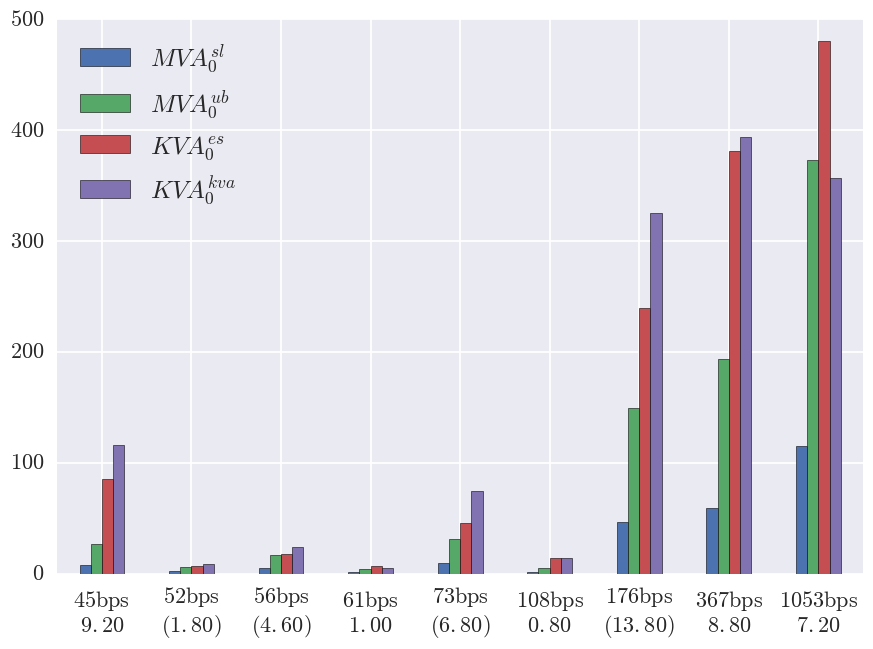

In [32]:
mkva0 = mkva0.reindex(labels_spreads)

mkva0.plot.bar(rot=0)
plt.gca().yaxis.set_major_formatter(formatter_tex_bps)

plt.legend(loc='best', fontsize=labelsize)
plt.tick_params(axis='both', which='major', labelsize=labelsize-2)

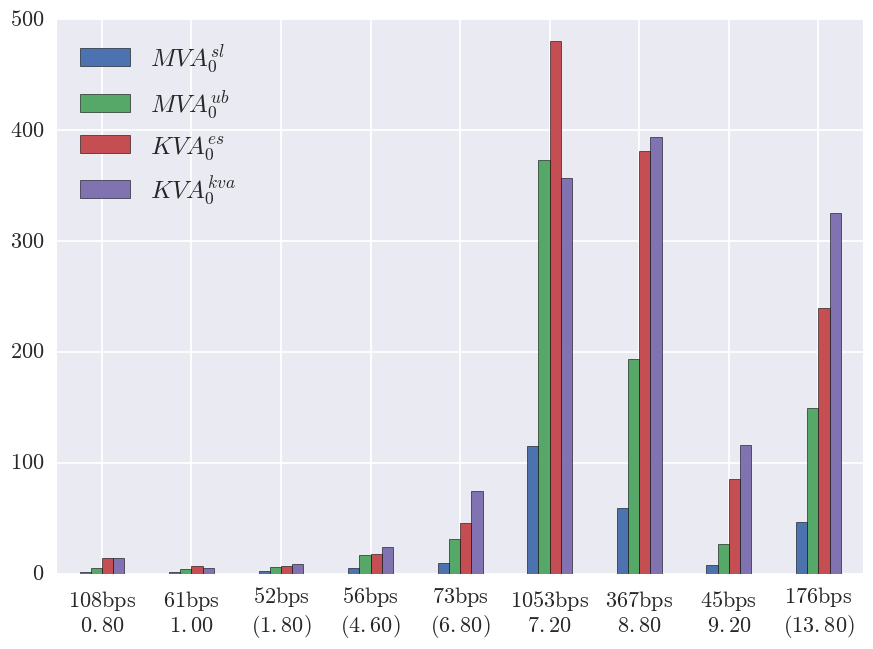

In [33]:
mkva0 = mkva0.reindex(labels_positions)

mkva0.plot.bar(rot=0)
plt.gca().yaxis.set_major_formatter(formatter_tex_bps)

plt.legend(loc='best', fontsize=labelsize)
plt.tick_params(axis='both', which='major', labelsize=labelsize-2)